# Programming for Data Science and Artificial Intelligence

## Energy

For this exercise we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1. ETL

In [2]:
df = pd.read_csv('Joules_of_Siam_Data - Electricity_Consumption_Monthly.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

251


,Residental <150,Residental > 150,Residental Total,Small General,Medium General,Large General,Specific Business,Gov & Nonprofit,Agriculture Pumping,Temporary,Stand By Rate,Interruptible Rate,Free of Charge,Total,Direct Customer,Grand total
Date,,,,,,,,,,,,,,,,
2002-02-01,510,1088,1597,719,1406,2797,238,260,26,31,1,76.0,74,7224,135,7359
2002-03-01,597,1246,1842,816,1664,3199,277,301,24,31,0,85.0,76,8316,155,8471
2002-04-01,662,1387,2049,863,1574,3014,290,287,23,34,0,86.0,86,8307,154,8461
2002-05-01,652,1338,1990,884,1670,3230,278,306,15,34,1,98.0,77,8582,149,8730
2002-06-01,588,1331,1919,855,1644,3206,264,332,14,34,1,96.0,76,8440,164,8604


## 2. EDA

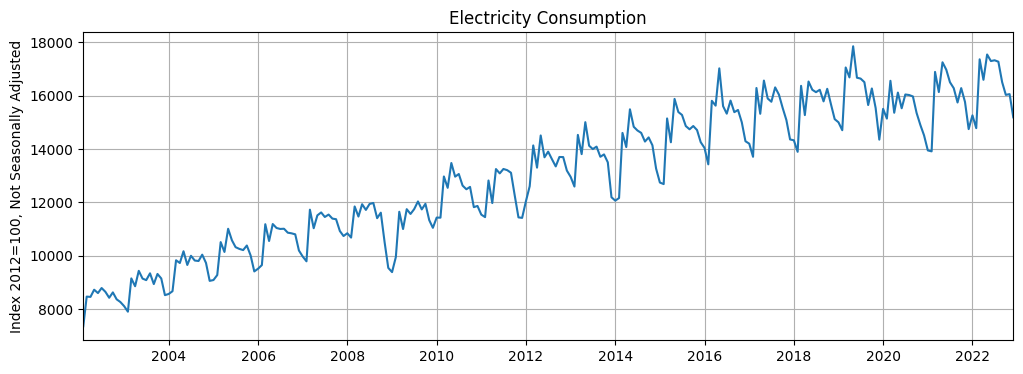

In [5]:
plt.figure(figsize=(12,4))
plt.title('Electricity Consumption')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Grand total'])
plt.show()

# 3. Prepare the data
We'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

### 3.1 Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [7]:
y = df['Grand total'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set  = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 239
Test:  12


## 3.2 Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 7359.0
First item, scaled: [-1.]


### 3.3 Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [9]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [10]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 227


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [11]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

### Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [13]:
epochs = 50

for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # OPTIONAL print statement
    print(f'{i+1} of {epochs} epochs completed')

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

## 5. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [27]:
future = 24
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
preds[window_size:]

[0.31110915541648865,
 0.3288181722164154,
 0.5056068897247314,
 0.6347850561141968,
 0.6487873792648315,
 0.6326079964637756,
 0.6206485033035278,
 0.619431734085083,
 0.6005054712295532,
 0.576007604598999,
 0.5392473936080933,
 0.47346416115760803,
 0.3755606412887573,
 0.3593893051147461,
 0.45368877053260803,
 0.5628371238708496,
 0.6511404514312744,
 0.6576839685440063,
 0.6523594856262207,
 0.6347038745880127,
 0.6104037761688232,
 0.5810497999191284,
 0.5484206676483154,
 0.4965169131755829]

### Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [28]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[14239.04529305],
       [14331.97335871],
       [15259.67215383],
       [15937.53458196],
       [16011.01177269],
       [15926.11046144],
       [15863.35302109],
       [15856.96802461],
       [15757.65246028],
       [15629.09990513],
       [15436.20069796],
       [15091.00318567],
       [14577.25446516],
       [14492.39537859],
       [14987.23182337],
       [15559.98780751],
       [16023.35951889],
       [16057.69662493],
       [16029.75640082],
       [15937.1085819 ],
       [15809.59381545],
       [15655.55882508],
       [15484.33745348],
       [15211.97250189]])

### Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

In [1]:
x = np.arange('2020-12-01', '2022-12-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Grand total'])
plt.plot(x,true_predictions)
plt.show()

NameError: name 'np' is not defined

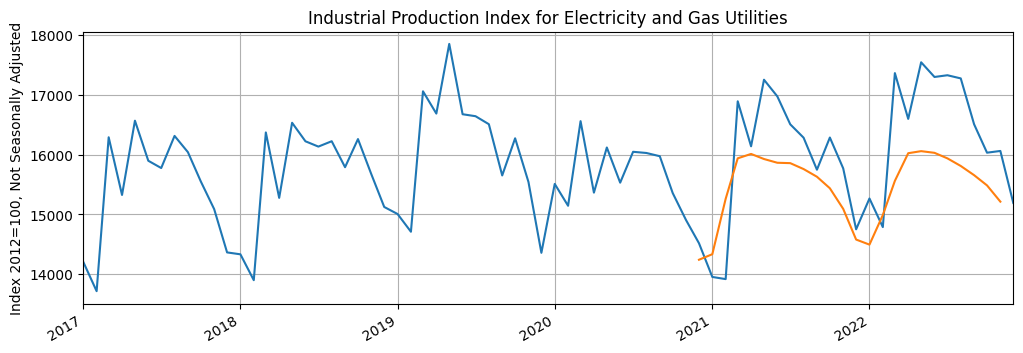

In [30]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['Grand total']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()